In [2]:
# .nii 파일 shape, metadata 확인

import nibabel as nib
import numpy as np

file_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/raw_prep_vol/sub-01/brainmask.nii.gz'
img = nib.load(file_path)
data = img.get_fdata()

print(data.shape)

header = img.header
print(header)

(81, 104, 83)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  81 104  83   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.  1.8 1.8 1.8 1.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 1
glmin           : 0
descrip         : b''
aux_file        : b'none'
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [  1.8   0. 

In [3]:
#.npy 파일 shape 확인

import numpy as np

file_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/nsdgeneral.npy'
data = np.load(file_path)
print(f"배열의 shape: {data.shape}")
print(data)


배열의 shape: (25611, 15724)
[[-0.4033  -0.6196  -0.931   ...  0.2277  -1.668   -0.5137 ]
 [ 0.666   -1.306   -0.6562  ...  0.9375  -1.32    -0.949  ]
 [-1.437   -0.5967   0.0484  ...  0.29    -1.243   -1.415  ]
 ...
 [-0.0887  -1.166   -1.354   ... -0.288   -1.013   -0.92   ]
 [-1.0625  -0.905   -0.2708  ... -1.827   -1.152   -0.05075]
 [ 0.2126   0.3867  -0.1448  ... -1.932    0.12195  0.9956 ]]


In [ ]:
import nibabel as nib
import numpy as np

# 파일 경로
beta_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/normalize/sub-01/betas_session03.nii.gz'

# 데이터 로드
beta_img = nib.load(beta_path)
beta_data = beta_img.get_fdata()  # shape: (x, y, z, t)

# t=1 (두 번째 timepoint)의 3D 볼륨
volume_t1 = beta_data[..., 1]  # shape: (x, y, z)

# 값이 0이 아닌 (x, y, z) 좌표의 개수 세기
non_zero_voxel_count = np.count_nonzero(volume_t1)

print(f"✅ t=1에서 intensity가 0이 아닌 복셀 수: {non_zero_voxel_count}")


In [3]:
# beta파일 bids 형식으로 만들기
import os
import re
import shutil

# 원본 루트 폴더
root_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi"
# 새로운 저장 루트 (BIDS 형식으로 저장할 곳)
output_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi2"

os.makedirs(output_dir, exist_ok=True)

for subject_folder in os.listdir(root_dir):
    subject_path = os.path.join(root_dir, subject_folder)
    if os.path.isdir(subject_path) and subject_folder.startswith("sub-"):
        subject_id = subject_folder.split("-")[1]

        for filename in os.listdir(subject_path):
            if filename.startswith("betas_session") and filename.endswith(".nii.gz"):
                session_match = re.search(r'session(\d+)', filename)
                if session_match:
                    session_num = session_match.group(1).zfill(2)
                    desc = "betaroi"  # 파일 이름
                    new_filename = f"sub-{subject_id}_ses-{session_num}_desc-{desc}.nii.gz"

                    bids_sub_dir = os.path.join(output_dir, f"sub-{subject_id}", f"ses-{session_num}", "func")
                    os.makedirs(bids_sub_dir, exist_ok=True)

                    src_file = os.path.join(subject_path, filename)
                    dst_file = os.path.join(bids_sub_dir, new_filename)
                    shutil.copy2(src_file, dst_file)

In [14]:
import nibabel as nib
import numpy as np

# z-score 정규화된 fMRI 파일
zscore_file = '/nas/research/03-Neural_decoding/3-bids/derivatives/new_b4_roi_zscore/sub-01/ses-01/func/sub-01_ses-01_desc-betaroizscore.nii.gz'
# 마스크 파일
mask_file = '/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_zscore/sub-01/sub-01_nsdgeneral.nii.gz'

# 데이터 로딩
zdata = nib.load(zscore_file).get_fdata()  # shape: (X, Y, Z, T)
mask = nib.load(mask_file).get_fdata() > 0  # shape: (X, Y, Z), boolean

# 시간축 기준 voxel-wise 평균/표준편차 계산 → shape: (X, Y, Z)
voxel_means = np.mean(zdata, axis=-1)
voxel_stds = np.std(zdata, axis=-1)

# 마스크 영역만 골라서 평균 계산
mean_of_means = np.mean(voxel_means[mask])
mean_of_stds = np.mean(voxel_stds[mask])

print(f"[Voxel-wise] 마스크 영역 평균들의 평균: {mean_of_means:.4f}")
print(f"[Voxel-wise] 마스크 영역 표준편차들의 평균: {mean_of_stds:.4f}")




[Voxel-wise] 마스크 영역 평균들의 평균: 0.0000
[Voxel-wise] 마스크 영역 표준편차들의 평균: 1.0000


In [10]:
#h5py 파일 압축 풀기

import h5py
import os
import numpy as np

def hdf5_to_folder(hdf5_path, output_dir):
    def recursively_save(h5_obj, current_path):
        for key in h5_obj:
            item = h5_obj[key]
            item_path = os.path.join(current_path, key)
            if isinstance(item, h5py.Dataset):
                # npy로 저장
                np.save(item_path + '.npy', item[()])
            elif isinstance(item, h5py.Group):
                os.makedirs(item_path, exist_ok=True)
                recursively_save(item, item_path)

    with h5py.File(hdf5_path, 'r') as f:
        os.makedirs(output_dir, exist_ok=True)
        recursively_save(f, output_dir)

# 사용 예
hdf5_to_folder(
    hdf5_path='/nas/research/03-Neural_decoding/3-bids/test_files/subj01_nsdgeneral.hdf5',
    output_dir='/nas/research/03-Neural_decoding/3-bids/test_files'
)

In [49]:
import numpy as np

voxels = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.coco73k.npy')
print(voxels)


#images = np.load('/nas/research/03-Neural_decoding/3-bids/subj01_nsdgeneral_extracted/images.npy')
#print(images.shape)

[2516]


Shape: (15724,)
Min: -3.752
Max: 3.53
Mean: -0.2416
Std: 0.8574
Median: -0.254


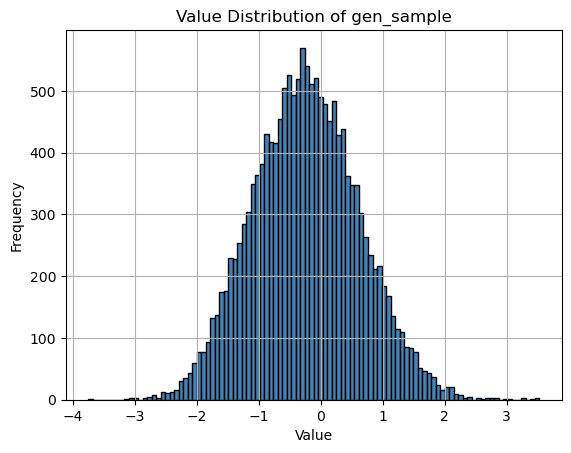

In [2]:
import numpy as np

gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.nsdgeneral.npy')[1]
# gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-21/func/sub-01_ses-21_desc-betaroizscore.npy')[329]

print("Shape:", gen_sample.shape)
print("Min:", np.min(gen_sample))
print("Max:", np.max(gen_sample))
print("Mean:", np.mean(gen_sample))
print("Std:", np.std(gen_sample))
print("Median:", np.median(gen_sample))
import matplotlib.pyplot as plt

plt.hist(gen_sample.flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Value Distribution of gen_sample")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [5]:
import numpy as np

# pixcorr 함수 정의
def pixcorr(a, b):
    return np.corrcoef(a.flatten(), b.flatten())[0, 1]

# --- 1. fMRI 응답 벡터 불러오기 ---
# (a) ses-36, TR 47
data1 = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-21/func/sub-01_ses-21_desc-betaroizscore.npy')
print(data1.shape)
vec1 = data1[329]  # shape: (15724,)

# (b) ses-37, TR 390
data2 = np.load('/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_new_zscore/sub-01/ses-24/func/sub-01_ses-24_desc-betaroizscore.npy')
print(data2.shape)
vec2 = data2[186]
vec3 = data2[329]

# --- 2. 생성 이미지의 feature 벡터 불러오기 ---
gen_sample = np.load('/nas/research/03-Neural_decoding/3-bids/train_subj01_0/sample000000300.nsdgeneral.npy')
print(gen_sample.shape)
# gen_sample shape = (3, 15724) 라면, 각 행이 하나의 샘플 벡터
gen1, gen2, gen3 = gen_sample[0], gen_sample[1], gen_sample[2]

# --- 3. pixcorr 계산 ---
print("pixcorr(vec1, gen1):", pixcorr(vec1, gen1))
print("pixcorr(vec2, gen2):", pixcorr(vec2, gen2))
print("pixcorr(vec3, gen3):", pixcorr(vec3, gen3))


(750, 15724)
(750, 15724)
(3, 15724)
pixcorr(vec1, gen1): -0.24386000123148174
pixcorr(vec2, gen2): -0.2520202925822968
pixcorr(vec3, gen3): -0.2735316386893801


In [6]:
import nibabel as nib
import os

# 원본 파일 경로
mgz_file = '/nas/research/03-Neural_decoding/3-bids/test_files/brainmask.mgz'

# 출력 파일 경로 (같은 디렉토리에 .nii.gz로 저장)
nii_gz_file = os.path.splitext(mgz_file)[0] + '.nii.gz'

# mgz 파일 로드
img = nib.load(mgz_file)

# nii.gz로 저장
nib.save(img, nii_gz_file)

print(f"변환 완료: {nii_gz_file}")


변환 완료: /nas/research/03-Neural_decoding/3-bids/test_files/brainmask.nii.gz
